# Implementing Differential Privacy with TensorFlow Privacy on IOT Dataset

# Overview of DP

**Differential privacy** (DP) is a framework for **measuring the privacy guarantees** provided by an algorithm. Through the lens of differential privacy, we can design machine learning algorithms that responsibly train models on private data. Learning with differential privacy provides provable guarantees of privacy, mitigating the risk of exposing sensitive training data in machine learning. Intuitively, a model trained with differential privacy should not be affected by any single training example, or small set of training examples, in its data set. This mitigates the risk of exposing sensitive training data in ML.

The basic idea of this approach, called differentially private stochastic gradient descent (DP-SGD), is to modify the gradients used in stochastic gradient descent (SGD), which lies at the core of almost all deep learning algorithms. Models trained with DP-SGD provide provable differential privacy guarantees for their input data. There are two modifications made to the vanilla SGD algorithm:



1.   First, the sensitivity of each gradient needs to be bounded. In other words, we need to limit how much each individual training point sampled in a minibatch can influence gradient computations and the resulting updates applied to model parameters. This can be done by clipping each gradient computed on each training point.
2.   Random noise is sampled and added to the clipped gradients to make it statistically impossible to know whether or not a particular data point was included in the training dataset by comparing the updates SGD applies when it operates with or without this particular data point in the training dataset.


**Problem Statement**: We want to implement Differential Privacy in a deep learning algorithm for an IOT dataset. We want to compare the performance of the model without DP and with DP implementation. We will also study how the model performance (Accuracy) varies with changing the DP parameter epsilon. 

Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using machine learning models.

**Dataset Details**: Occupancy Detection Data Set
Link to download: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Attribute Information:

*   Temperature, in Celsius
*   Relative Humidity, %
*   Light, in Lux
*   CO2, in ppm
*   Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
*  Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status




## Setup

Import Libraries 

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
import itertools
from google.colab import drive
from google.colab import files

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#drive.mount('/gdrive')
gdrive_data_path = 'data/occupancy_data/'

seed = 7
np.random.seed(seed)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Import tensorflow privacy library

In [ ]:
!pip install tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

##Load and pre-process the dataset

Download the datasets from the link provided and uploaded in google drive location. Preprocess the dataset.

In [ ]:
def load_data(file_name, dataset_type, display_data=False):
  df = pd.read_csv(gdrive_data_path + file_name, sep=",")
  df.drop('date', axis=1, inplace=True)
  cols = df.columns[df.columns != 'Occupancy']
  df[df.columns] = df[df.columns].apply(pd.to_numeric)
  df[['Temperature', 'Light', 'CO2']] = np.round(df[['Temperature', 'Light', 'CO2']],2)
  df[['Humidity']] = np.round(df[['Humidity']],4)
  df[['HumidityRatio']] = np.round(df[['HumidityRatio']],6)
  if display_data:
    print("#### Preview data ####")
    print(df.head())
  x = df[cols]
  y = df[['Occupancy']]
  print(dataset_type + " Shape:", x.shape, y.shape)
  return (x,y)

In [ ]:
train = load_data('datatraining.txt', 'Train', True)
val = load_data('datatest.txt', 'Test', True)
test = load_data('datatest2.txt', 'Test', True)

train_data, train_labels = train
val_data, val_labels = val
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)
val_data = np.array(val_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)

#train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
#test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

train_labels = np.array(train_labels, dtype=np.int32)
val_labels = np.array(val_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

print(train_data.shape, val_data.shape, test_data.shape, train_labels.shape, val_labels.shape, test_labels.shape)
feature_size = train_data.shape[1]

#### Preview data ####
   Temperature  Humidity  Light     CO2  HumidityRatio  Occupancy
1        23.18   27.2720  426.0  721.25       0.004793          1
2        23.15   27.2675  429.5  714.00       0.004783          1
3        23.15   27.2450  426.0  713.50       0.004779          1
4        23.15   27.2000  426.0  708.25       0.004772          1
5        23.10   27.2000  426.0  704.50       0.004757          1
Train Shape: (8143, 5) (8143, 1)
#### Preview data ####
     Temperature  Humidity   Light     CO2  HumidityRatio  Occupancy
140        23.70    26.272  585.20  749.20       0.004764          1
141        23.72    26.290  578.40  760.40       0.004773          1
142        23.73    26.230  572.67  769.67       0.004765          1
143        23.72    26.125  493.75  774.75       0.004744          1
144        23.75    26.200  488.60  779.00       0.004767          1
Test Shape: (2665, 5) (2665, 1)
#### Preview data ####
   Temperature  Humidity   Light      CO2  HumidityRatio

Data Normalisation: The features have been normalised using MinMax Scaler.

In [ ]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

##Define and tune learning model hyperparameters
Set learning model hyperparamter values

In [ ]:
epochs = 30
batch_size = 32
learning_rate = 0.01

# Other hyperparameters and functions
kernel_regularization = 0.001 #1.2 #0.001352
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer

def reshaper(arr, batch_size):
  arr = arr[:-(arr.shape[0] % batch_size),:]
  return arr


train_data = reshaper(train_data, batch_size)
train_labels = reshaper(train_labels, batch_size)
val_data = reshaper(val_data, batch_size)
val_labels = reshaper(val_labels, batch_size)
test_data = reshaper(test_data, batch_size)
test_labels = reshaper(test_labels, batch_size)

##Build the learning model without DP

In [ ]:
classifier = tf.keras.Sequential([
        tf.keras.Input((feature_size,), name='feature'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax, kernel_regularizer=l1(kernel_regularization))
    ])

optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.compat.v2.losses.Reduction.NONE)

# Compile model with Keras
classifier.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

classifier.fit(train_data,
           train_labels,
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(val_data, val_labels),
           verbose=1)

Train on 8128 samples, validate on 2656 samples
Epoch 1/30
8128/8128 [==============================] - 1s 95us/sample - loss: 0.3731 - acc: 0.9841 - val_loss: 0.3642 - val_acc: 0.9782
Epoch 2/30
8128/8128 [==============================] - 1s 87us/sample - loss: 0.3509 - acc: 0.9884 - val_loss: 0.3563 - val_acc: 0.9785
Epoch 3/30
8128/8128 [==============================] - 1s 85us/sample - loss: 0.3454 - acc: 0.9884 - val_loss: 0.3526 - val_acc: 0.9785
Epoch 4/30
8128/8128 [==============================] - 1s 86us/sample - loss: 0.3425 - acc: 0.9884 - val_loss: 0.3502 - val_acc: 0.9782
Epoch 5/30
8128/8128 [==============================] - 1s 89us/sample - loss: 0.3404 - acc: 0.9883 - val_loss: 0.3485 - val_acc: 0.9785
Epoch 6/30
8128/8128 [==============================] - 1s 89us/sample - loss: 0.3388 - acc: 0.9883 - val_loss: 0.3471 - val_acc: 0.9782
Epoch 7/30
8128/8128 [==============================] - 1s 88us/sample - loss: 0.3375 - acc: 0.9883 - val_loss: 0.3461 - val_acc: 

##Model Evaluation on test data (without DP)

In [ ]:
loss, accuracy = classifier.evaluate(test_data, test_labels, batch_size=batch_size)

9728/9728 [==============================] - 0s 49us/sample - loss: 0.3315 - acc: 0.9907


##Build the learning model with DP

### Privacy specific Hyperparameters

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. **Generally, more noise results in better privacy** (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. **The number of microbatches should evenly divide the batch size. **
4. `learning_rate` (float) - This hyperparameter already exists in vanilla SGD. The higher the learning rate, the more each update matters. If the updates are noisy (such as when the additive noise is large compared to the clipping threshold), a low learning rate may help the training procedure converge. 

Use the hyperparameter values below to obtain a reasonably accurate model (95% test accuracy):

In [ ]:
# DP hyperparameters
l2_norm_clip = 0.8 #1.0
noise_multiplier = 0.8
microbatches_perc = .5
learning_rate = 0.01

In [ ]:
DP_classifier = tf.keras.Sequential([
        tf.keras.Input((feature_size,), name='feature'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax, kernel_regularizer=l1(kernel_regularization))
    ])

optimizer = DPGradientDescentGaussianOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=int(microbatches_perc * batch_size),
            learning_rate=learning_rate)

# Compute vector of per-example loss rather than its mean over a minibatch.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.compat.v2.losses.Reduction.NONE)

DP_classifier.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

DP_classifier.fit(train_data,
           train_labels,
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(val_data, val_labels),
           verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8128 samples, validate on 2656 samples
Epoch 1/30
8128/8128 [==============================] - 5s 639us/sample - loss: 0.5502 - acc: 0.9135 - val_loss: 0.4908 - val_acc: 0.9688
Epoch 2/30
8128/8128 [==============================] - 5s 611us/sample - loss: 0.4374 - acc: 0.9844 - val_loss: 0.4354 - val_acc: 0.9695
Epoch 3/30
8128/8128 [==============================] - 5s 615us/sample - loss: 0.4066 - acc: 0.9873 - val_loss: 0.4127 - val_acc: 0.9703
Epoch 4/30
8128/8128 [==============================] - 5s 618us/sample - loss: 0.3919 - acc: 0.9884 - val_loss: 0.4002 - val_acc: 0.9703
Epoch 5/30
8128/8128 [==============================] - 5s 626us/sample - loss: 0.3839 - acc: 0.9883 - val_loss: 0.3929 - val_acc: 0.9703
Epoch 6/30
8128/8128 [==============================] - 5s 620us/sample - loss: 0.3786 - acc: 0.9882 - val_loss: 0.3874 - val_acc: 0.9706
Epoch 7/30
8128/8128 [========

## Model Evaluation on test data (With DP)

In [ ]:
loss, accuracy = DP_classifier.evaluate(test_data, test_labels, batch_size=batch_size)

9728/9728 [==============================] - 0s 49us/sample - loss: 0.3637 - acc: 0.9855


## Measure the differential privacy guarantee

Perform a privacy analysis to measure the DP guarantee achieved by a training algorithm. Knowing the level of DP achieved enables the objective comparison of two training runs to determine which of the two is more privacy-preserving. At a high level, the privacy analysis measures how much a potential adversary can improve their guess about properties of any individual training point by observing the outcome of our training procedure (e.g., model updates and parameters). 

This guarantee is sometimes referred to as the **privacy budget**. A lower privacy budget bounds more tightly an adversary's ability to improve their guess. This ensures a stronger privacy guarantee. Intuitively, this is because it is harder for a single training point to affect the outcome of learning: for instance, the information contained in the training point cannot be memorized by the ML algorithm and the privacy of the individual who contributed this training point to the dataset is preserved.

In this tutorial, the privacy analysis is performed in the framework of Rényi Differential Privacy (RDP), which is a relaxation of pure DP based on [this paper](https://arxiv.org/abs/1702.07476) that is particularly well suited for DP-SGD.


Two metrics are used to express the DP guarantee of an ML algorithm:

1.   **Delta** ($\delta$) - Bounds the probability of the privacy guarantee not holding. A rule of thumb is to set it to be ***less than the inverse of the size of the training dataset***. 
2.   **Epsilon** ($\epsilon$) - This is the **privacy budget**. It measures the strength of the privacy guarantee by bounding how much the probability of a particular model output can vary by including (or excluding) a single training point. **A smaller value for $\epsilon$ implies a better privacy guarantee**. However, the $\epsilon$ value is only an upper bound and a large value could still mean good privacy in practice.

Tensorflow Privacy provides a tool, `compute_dp_sgd_privacy.py`, to compute the value of $\epsilon$ given a fixed value of $\delta$ and the following hyperparameters from the training process:

1.   The total number of points in the training data, `n`.
2. The `batch_size`.
3.   The `noise_multiplier`.
4. The number of `epochs` of training.


In [ ]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=10, delta=1e-5)

DP-SGD with sampling rate = 0.394% and noise_multiplier = 0.8 iterated over 2540 steps satisfies differential privacy with eps = 2.87 and delta = 1e-05.
The optimal RDP order is 6.0.


(2.874072132038394, 6.0)

## Hyperparameter Tuning

Initially, we trained 108 models to study the variation of different hyperparameters with Test set accuracy and epsilon to coarsely identify the parameters to choose from.

Then in order to see the variation of epsilon with delta we kept all other hyper parameters constant and varied delta for wide range of values. 

Similarly, we studied the variation of other hyper parameters with epsilon.








In [ ]:
epochs=30
def create_model(l2_norm_clip=0.0, noise_multiplier=0.0, microbatches_perc=0.5, learning_rate=0.1, delta=1e-4, kernel_regularization=0.001):
	# create model
  model = tf.keras.Sequential([
        tf.keras.Input((feature_size,), name='feature'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax, kernel_regularizer=l1(kernel_regularization))
    ])
  optimizer = DPGradientDescentGaussianOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=int(microbatches_perc * batch_size),
            learning_rate=learning_rate)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.compat.v2.losses.Reduction.NONE)

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # fit the model
  res = model.fit(train_data,
          train_labels,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_data, val_labels),
          verbose=0)
  
  # look at the last 10 epochs. Get the mean and standard deviation of the validation score.
  last10_scores = np.array(res.history['val_acc'][-10:])
  mean_val_acc = last10_scores.mean()
  std_val_acc = last10_scores.std()

  # If the model didn't converge then set a high loss.
  if np.isnan(mean_val_acc):
      return 9999.0, 0.0

  #Evaluate test data performance
  test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)

  #Compute epsilon
  dp_res = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=delta)
  epsilon = dp_res[0]
  return mean_val_acc, std_val_acc, test_accuracy, epsilon


def model_tuning():
  #l2_norm_clip = [1.5]
  l2_norm_clip = [3.0, 2.5, 2.0, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.025, 0.05, 0.075, 0.001, 0.0025, 0.005]
  noise_multiplier = [0.8]
  #noise_multiplier = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.025, 0.05, 0.075, 0.001, 0.0025, 0.005, 0.0001, 0.0005]
  microbatches_perc = [0.5]
  learning_rate = [0.1]
  delta = [0.8]
  kernel_regularization = [0.001352]

  parameters = [params for params in itertools.product(l2_norm_clip, noise_multiplier, microbatches_perc, learning_rate, delta, kernel_regularization)]

  for i,param in enumerate(parameters):
    total_models = len(parameters)
    l2_norm_clip = param[0]
    noise_multiplier = param[1]
    microbatches_perc = param[2]
    learning_rate = param[3]
    delta = param[4]
    kernel_regularization = param[5]
    print("Model tuning in progress --- ", i+1, "/", total_models)
    print(l2_norm_clip, noise_multiplier, learning_rate, delta, kernel_regularization)
    mean_val_acc, std_val_acc, test_accuracy, epsilon = create_model(l2_norm_clip, noise_multiplier, microbatches_perc, learning_rate, delta, kernel_regularization)
    
    col_names = ['experiment_no', 'epochs', 'batch_size', 'l2_norm_clip', 'noise_multiplier', 'microbatches_perc', 'learning_rate', 'delta', 'kernel_regularization', \
                'mean_val_acc', 'std_val_acc', 'test_accuracy', 'epsilon']
    res_data = [[i+1,epochs, batch_size, l2_norm_clip, noise_multiplier, microbatches_perc, learning_rate, delta, kernel_regularization, mean_val_acc, std_val_acc,\
                test_accuracy, epsilon]]
    res = pd.DataFrame(data = res_data, columns = col_names)
    if i == 0:
      results = res.copy()
    else:
      results = pd.concat([results, res], axis=0)
    results.reset_index(inplace=True, drop=True)
  return results



# Training the model
results = model_tuning()

#Writing results to local machine for later analysis
results.sort_values(by='epsilon', axis=0, ascending=True, inplace=True)
results.to_csv('DP_results3.csv')
files.download('DP_results3.csv')

## Comparison Plots

Delta vs Epsilon Plot

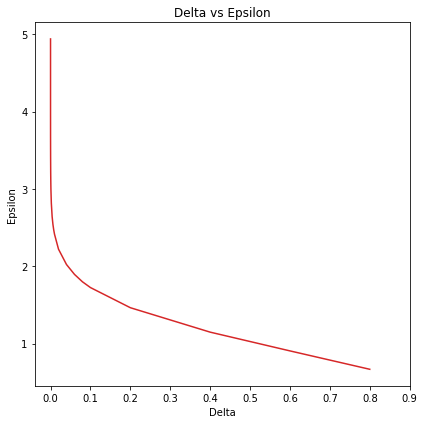

In [ ]:
mpl.rcParams['figure.figsize'] = (6, 6)
results = pd.read_csv(gdrive_data_path + 'DP_results1.csv', sep=",")
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Delta')
ax1.set_ylabel('Epsilon')
ax1.plot(results.delta, results.epsilon, color=color)
ax1.tick_params(axis='y')
plt.xticks(np.arange(1e-7, 1, step=0.1)) 
plt.title("Delta vs Epsilon")
fig.tight_layout()
plt.show()

## Summary

In this experiment, we learned about differential privacy (DP) and how we can implement DP principles in existing ML algorithms to provide privacy guarantees for training data. In particular, we learned how to:

* Wrap existing optimizers (e.g., SGD, Adam) into their differentially private counterparts using TensorFlow Privacy
* Tune hyperparameters introduced by differentially private machine learning
* Measure the privacy guarantee provided using analysis tools included in TensorFlow Privacy